## Code references :-
* https://github.com/ZhenguoChen/Neural-Network-Image-Captioning 

In [1]:
#importing the lib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image 
import glob
import pickle 
from time import time

from keras.preprocessing import sequence 
from keras.models import Sequential
from keras.layers import LSTM ,Embedding, TimeDistributed ,Dense ,RepeatVector,Merge,\
                    Activation, Flatten ,Reshape,concatenate, Dropout, BatchNormalization
from keras.optimizers import adam ,RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers

In [3]:
#Below file contains captions for every image - each image is assigned 5 reference captions
token=r"C:\Users\**\Desktop\jupyter\image captioning\Flickr8k.token.txt"

#read the file and create a list containing all the lines in the file
f=open(token,'r')
captions =f.read().strip().split('\n')
f.close()

In [4]:
#create a dict which contains image name as keys and the list of related captions as values
d={}
for i,row in enumerate(captions):
    #split the name and the caption in each row
    row= row.split('\t')
    #remove the last 2 characters which indicate the caption number
    row[0]=row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else :
        d[row[0]]=[row[1]]

In [5]:
#Below path contains all the images
images=r"C:\Users\**\Desktop\jupyter\image captioning\Flicker8k_Dataset/"
#create a list of all image names in the dict
img = glob.glob(images+'*.jpg')

In [6]:
len(img)

8091

In [7]:
#Below file contains the names of images to be used in train data
train_images_file=r'C:\Users\**\Desktop\jupyter\image captioning\Flickr_8k.trainImages.txt'
#read the train image names in a set
train_images=set(open(train_images_file,'r').read().strip().split('\n'))

#create a list of all the training images with their full path names
train_img=[]

for i in img: #img is a list of full path names of all images
    if i[len(images):] in train_images: #check if the image belongs to training set
        train_img.append(i)

In [8]:
#Below file conntains the images to be used in validation data
val_images_file =r'C:\Users\**\Desktop\jupyter\image captioning\Flickr_8k.devImages.txt'
#Read the validation image names in a set
val_images=set(open(val_images_file,'r').read().strip().split('\n'))

#create a list of all the validation images with their full path names
val_img=[]

for i in img:
    if i[len(images):] in val_images:
        val_img.append(i)

In [9]:
#Below file conntains the images to be used in test data
test_images_file =r'C:\Users\**\Desktop\jupyter\image captioning\Flickr_8k.testImages.txt'
#Read the test image names in a set
test_images=set(open(test_images_file,'r').read().strip().split('\n'))

#create a list of all the test images with their full path names
test_img=[]

for i in img:
    if i[len(images):] in test_images:
        test_img.append(i)

In [10]:
def preprocess(image_path):
    # convert all the images to size 299x299 as expected by the inception v3 model
    img=image.load_img(image_path,target_size=(299,299))
    #convert PIL image to numpy array of 3-D
    x=image.img_to_array(img)
    #add one more dimension
    x=np.expand_dims(x,axis=0)
    #preprocess the images using preprocess_input() from inception module
    x=preprocess_input(x)
    return x

In [11]:
#load the inception v3 model
model=InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 225s 2us/step


In [12]:
#create a newe model by removing the last layer(o/p layer) from inceptionv3
model_new=Model(model.input,model.layers[-2].output)

In [15]:
#function to encode a given image into a vector of size (2048,)
def encode(image):
    image =preprocess(image) #preprocess the image
    fea_vec=model_new.predict(image) #get the encoding vector for the image(4D array/tensor)
    fea_vec=np.reshape(fea_vec,fea_vec.shape[1]) #reshape from (1,2048) to (2048,)
    return fea_vec

In [22]:
#call the function to encode all the train images
start=time()
encoding_train={}
for img in train_img:
    encoding_train[img[len(images):]]=encode(img)
print("time taken in seconds : ",time()-start)

time taken in seconds :  691.9962589740753


In [25]:
#save the bottleneck train features to disk
with open("Pickle,encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [26]:
#call the function to encode all the test images
start=time()
encoding_test={}
for img in test_img:
    encoding_test[img[len(images):]]=encode(img)
print("time taken in seconds : ",time()-start)

time taken in seconds :  111.45676589012146


In [27]:
#save the bottleneck test features to disk
with open("Pickle,encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test,encoded_pickle)

#### Loading files again into memory

In [10]:
#load the bottleneck trian features
with open("Pickle,encoded_train_images.pkl","rb") as encoded_pickle:
    encoding_train=pickle.load(encoded_pickle)

In [11]:
#load the bottleneck test features
with open("Pickle,encoded_test_images.pkl","rb") as encoded_pickle:
    encoding_test=pickle.load(encoded_pickle)

#### Seperate out the train,test and validation data form dict. "d" created above

In [12]:
train_d={}
for i in train_img:
    if i[len(images):] in d:
        train_d[i]=d[i[len(images):]]

In [13]:
val_d={}
for i in val_img:
    if i[len(images):] in d:
        val_d[i]=d[i[len(images):]]

In [14]:
test_d={}
for i in test_img:
    if i[len(images):] in d:
        test_d[i]=d[i[len(images):]]

In [15]:
#create a list of all captions in train data
all_train_captions=[]
for key,val in train_d.items():
    for cap in val:
        #add full-stop at the end of caption if not already present
        if cap[-1] == '.':
            all_train_captions.append(cap)
        else:
            all_train_captions.append(cap+' .')

In [16]:
len(all_train_captions)

30000

In [17]:
#consider only those words which appers at least 20 times in the corpus
word_count_threshold =20

#key:- word, value :- no. of times it appears
word_counts ={}
nsents=0
for sent in all_train_captions:
    nsents +=1
    for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w,0) +1
vocab =[ w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' %(len(word_counts),len(vocab)))

preprocessed words 7705 -> 1068


* the numbers above can be slightly different

In [18]:
#create two dict. 

#Index to word dictionary
ixtoword ={}
ixtoword[0]='#start#'

#word to index dictionary 
wordtoix={}
wordtoix['#start#']=0

In [19]:
ix=1
for w in vocab:
    wordtoix[w]=ix
    ixtoword[ix]=w
    ix +=1

In [20]:
# '#start#' and '.' is equal to no. of sentences
word_counts['.']= nsents
word_counts['#start#']=nsents

In [21]:
n_words=len(wordtoix)
n_words

1069

In [22]:
#calc length of max. caption
maxlen=np.max([x for x in map(lambda x: len(x.split(' ')),captions)])
maxlen

38

In [45]:
#create a new file containing train image names and their captions
f=open('training_dataset.txt','w')
f.write("image_id\tcaptions\n")

for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):]+"\t"+i+"\n")
        
f.close()

In [23]:
#read the file in a dataframe
df=pd.read_csv('training_dataset.txt',delimiter='\t')
df.head(10)

,image_id,captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [24]:
# create an iterator of the dataframe
iter=df.iterrows()
imgs=[]
caps=[]

#iterate over each row of dataframe
for i in range(df.shape[0]):
    x=next(iter)
    imgs.append(x[1][0]) #store the image name
    caps.append(x[1][1]) #store the corresponding caption

In [25]:
len(caps), len(imgs)

(30000, 30000)

In [26]:
caps[0],imgs[0]

('A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg')

## Model

In [27]:
#Hyper parameters
DIM_INPUT=2048
DIM_EMBED=256
DIM_HIDDEN=256
MAX_LEN=maxlen
BATCH_SIZE=128
N_WORDS=n_words

##### The model architecture is as follows:

![title](Images/model.jpg)

* FEAT - image features
* CAPTIONS - for training, true caption. For prediction, initially #start# tag and then previous prediction
* MASK - record previous words
* POSITION(pos) - position of current word in a sentence

In [78]:
#Index  of current word
sent_input = Input(shape=(1,))
#Image features
img_input= Input(shape=(DIM_INPUT,))
#mask on words already generated in the caption
mask_input=Input(shape=(N_WORDS,))
#position of the current word in the caption
position_input=Input(shape=(MAX_LEN,))

#add embedding layer to the current word
sent_embed_layer=Embedding(output_dim=DIM_EMBED,input_dim=N_WORDS,input_length=1)(sent_input)
sent_embed_layer=Reshape((DIM_EMBED,))(sent_embed_layer)
#concatenate [current word, position]
sent_embed_layer=concatenate([sent_embed_layer,position_input])
#add a dense layer to make output of size "DIM_EMBED"
sent_embed_layer=Dense(DIM_EMBED)(sent_embed_layer)

#concatenate image features ,[current word,position] and mask
img_sent_merge_layer=concatenate([img_input,sent_embed_layer,mask_input])
img_sent_merge_layer=Reshape((1,DIM_HIDDEN+DIM_INPUT+N_WORDS))(img_sent_merge_layer)

#Add LSTM with 512 units
lstm=LSTM(512)(img_sent_merge_layer)
#add dropout
lstm=Dropout(0.25)(lstm)
#add output layers of size "N_WORDS" (size of vocabulary)
lstm=Dense(N_WORDS)(lstm)
#add batch normaliztion
lstm=BatchNormalization()(lstm)
#activation of ouput layer is softmax
out=Activation('softmax')(lstm)

#final model
model=Model(input=[img_input,sent_input,mask_input,position_input],output=out)

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [79]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.001,
                                                                       beta_1=0.9,
                                                                       beta_2=0.999,
                                                                       epsilon=1e-08,
                                                                       decay=0))

In [80]:
#create an iterator over all the captions
index=(np.arange(len(all_train_captions)).astype(int))
#randomly shuffle the iterator
np.random.shuffle(index)

In [81]:
epochs=20
epoch_time=[]
total_feats=len(all_train_captions)

In [82]:
for epoch in range(epochs):
    begin=time()
    #below loop processes one batch at a time
    for start , end in zip(range(0,len(index),BATCH_SIZE),range(BATCH_SIZE,len(index)+1,BATCH_SIZE)):
        current_caption_ind=[]#index of the current word
        next_caption_ind=[]#index of the next word (to be predicted)
        position=[]#position of the current word in the caption
        current_mask_matrix=[]#mask on all the previous words generated in the caption
        current_feats=[]#features of the current image
        current_batch=0
        
        #extract the captions of the current batch
        current_captions=np.array(caps)[index[start:end]]
        
        #processing the current batch of inputs
        for j,cap in zip(index[start:end],current_captions):
            #get the features of the current image
            feat=encoding_train[imgs[j]]
            #add #start# in the beginning of the current caption
            cap='#start# ' + cap
            #get the index of each word in the caption
            indices=[wordtoix[word] for word in cap.lower().split(' ') if word in wordtoix]
            #each word will become the current word as time steps proceed,only except the last word(full-stop)
            current_caption_ind.extend(indices[:-1])
            #initialize all the maskes to zero
            current_mask=np.zeros((len(indices)-1,n_words))
            
            #prepare the data for current batch
            for i in range(1,len(indices)):
                #word to be predicted
                next_cap=np.zeros((n_words))
                next_cap[indices[i]]=1
                #mark position of current word
                cur_position =np.zeros((MAX_LEN))
                cur_position[i-1]=1
                
                #mask all the previous words in the caption
                if i<len(indices)-1:
                    current_mask[i,:]=np.logical_or(current_mask[i,:],current_mask[i-1,:])
                    current_mask[i,indices[i-1]]=1
                    
                #prepare the tensors
                next_caption_ind.append(next_cap)
                position.append(cur_position)
                current_feats.append(feat)
                #increment batch size (each time step is one batch)
                current_batch+=1
                
            #prepare the mask tensor
            current_mask_matrix.extend(current_mask)
            
        #fit the model on the current batch of inputs
        result=model.fit([np.array(current_feats),np.array(current_caption_ind),
                         np.array(current_mask_matrix),np.array(position)],
                        np.array(next_caption_ind),
                        batch_size=current_batch,epochs=1)
        print('epoch {0}, process {1}/{2}'.format(epoch,start,total_feats))
    #save the results of current epoch
    epoch_file ='model/checkpoint_{0}.h5'.format(epoch)
    #save the weigths after the current epcoh
    model.save_weights(epoch_file)
    end=time()
    epoch_time.append('epoch {0} use time: {1}'.format(epoch,end-begin))
    print(epoch_time)

Epoch 1/1
2896/2896 [==============================] - 3s 1ms/step - loss: 7.3633
epoch 0, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 1s 183us/step - loss: 7.2473
epoch 0, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 1s 185us/step - loss: 7.2009
epoch 0, process 512/30000
Epoch 1/1
2834/2834 [==============================] - 0s 173us/step - loss: 7.0650
epoch 0, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 160us/step - loss: 7.0137
epoch 0, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 162us/step - loss: 6.9594
epoch 0, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 167us/step - loss: 6.8789
epoch 0, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 166us/step - loss: 6.8158
epoch 0, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 1s 187us/step - loss: 6.7323
epoch 0, process 2048/30000


2724/2724 [==============================] - 0s 169us/step - loss: 5.0863
epoch 0, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 166us/step - loss: 5.0534
epoch 0, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 166us/step - loss: 5.0959
epoch 0, process 19200/30000
Epoch 1/1
2875/2875 [==============================] - 0s 166us/step - loss: 5.0688
epoch 0, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 164us/step - loss: 5.0465
epoch 0, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 0s 162us/step - loss: 5.0440
epoch 0, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 0s 164us/step - loss: 5.0114
epoch 0, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 165us/step - loss: 5.0251
epoch 0, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 166us/step - loss: 5.0470
epoch 0, process 20736

epoch 1, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 168us/step - loss: 4.4410
epoch 1, process 7424/30000
Epoch 1/1
2874/2874 [==============================] - 0s 165us/step - loss: 4.3662
epoch 1, process 7680/30000
Epoch 1/1
2782/2782 [==============================] - 0s 165us/step - loss: 4.3453
epoch 1, process 7936/30000
Epoch 1/1
2752/2752 [==============================] - 0s 164us/step - loss: 4.4220
epoch 1, process 8192/30000
Epoch 1/1
2755/2755 [==============================] - 0s 164us/step - loss: 4.4094
epoch 1, process 8448/30000
Epoch 1/1
2781/2781 [==============================] - 0s 164us/step - loss: 4.4179
epoch 1, process 8704/30000
Epoch 1/1
2753/2753 [==============================] - 0s 169us/step - loss: 4.4238
epoch 1, process 8960/30000
Epoch 1/1
2801/2801 [==============================] - 0s 175us/step - loss: 4.4491
epoch 1, process 9216/30000
Epoch 1/1
2853/2853 [==============================] - 0s 167us/step - loss:

epoch 1, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 0s 165us/step - loss: 4.1314
epoch 1, process 26112/30000
Epoch 1/1
2832/2832 [==============================] - 0s 168us/step - loss: 4.1061
epoch 1, process 26368/30000
Epoch 1/1
2728/2728 [==============================] - 0s 175us/step - loss: 4.1846
epoch 1, process 26624/30000
Epoch 1/1
2827/2827 [==============================] - 0s 170us/step - loss: 4.1327
epoch 1, process 26880/30000
Epoch 1/1
2753/2753 [==============================] - 0s 165us/step - loss: 4.0886
epoch 1, process 27136/30000
Epoch 1/1
2796/2796 [==============================] - 0s 168us/step - loss: 4.1174
epoch 1, process 27392/30000
Epoch 1/1
2829/2829 [==============================] - 0s 176us/step - loss: 4.1248
epoch 1, process 27648/30000
Epoch 1/1
2820/2820 [==============================] - 0s 171us/step - loss: 4.0874
epoch 1, process 27904/30000
Epoch 1/1
2872/2872 [==============================] - 0s 172us/ste

2807/2807 [==============================] - 0s 162us/step - loss: 3.8089
epoch 2, process 14592/30000
Epoch 1/1
2925/2925 [==============================] - 0s 163us/step - loss: 3.8426
epoch 2, process 14848/30000
Epoch 1/1
2927/2927 [==============================] - 0s 162us/step - loss: 3.7974
epoch 2, process 15104/30000
Epoch 1/1
2696/2696 [==============================] - 0s 164us/step - loss: 3.8725
epoch 2, process 15360/30000
Epoch 1/1
2904/2904 [==============================] - 0s 167us/step - loss: 3.8297
epoch 2, process 15616/30000
Epoch 1/1
2951/2951 [==============================] - 0s 169us/step - loss: 3.9424
epoch 2, process 15872/30000
Epoch 1/1
2800/2800 [==============================] - 0s 171us/step - loss: 3.8545
epoch 2, process 16128/30000
Epoch 1/1
2875/2875 [==============================] - 0s 170us/step - loss: 3.8533
epoch 2, process 16384/30000
Epoch 1/1
2894/2894 [==============================] - 0s 165us/step - loss: 3.8051
epoch 2, process 16640

epoch 3, process 2816/30000
Epoch 1/1
2754/2754 [==============================] - 0s 167us/step - loss: 3.5790
epoch 3, process 3072/30000
Epoch 1/1
2827/2827 [==============================] - 0s 167us/step - loss: 3.6323
epoch 3, process 3328/30000
Epoch 1/1
2750/2750 [==============================] - 0s 166us/step - loss: 3.6341
epoch 3, process 3584/30000
Epoch 1/1
2806/2806 [==============================] - 0s 167us/step - loss: 3.5742
epoch 3, process 3840/30000
Epoch 1/1
2868/2868 [==============================] - 0s 167us/step - loss: 3.6570
epoch 3, process 4096/30000
Epoch 1/1
2756/2756 [==============================] - 0s 169us/step - loss: 3.6383
epoch 3, process 4352/30000
Epoch 1/1
2764/2764 [==============================] - 0s 167us/step - loss: 3.6268
epoch 3, process 4608/30000
Epoch 1/1
2905/2905 [==============================] - 0s 164us/step - loss: 3.6282
epoch 3, process 4864/30000
Epoch 1/1
2785/2785 [==============================] - 0s 166us/step - loss:

epoch 3, process 21504/30000
Epoch 1/1
2851/2851 [==============================] - 0s 167us/step - loss: 3.4286
epoch 3, process 21760/30000
Epoch 1/1
2960/2960 [==============================] - 0s 165us/step - loss: 3.5519
epoch 3, process 22016/30000
Epoch 1/1
2747/2747 [==============================] - 0s 168us/step - loss: 3.4454
epoch 3, process 22272/30000
Epoch 1/1
2834/2834 [==============================] - 0s 164us/step - loss: 3.5051
epoch 3, process 22528/30000
Epoch 1/1
2906/2906 [==============================] - 0s 166us/step - loss: 3.4450
epoch 3, process 22784/30000
Epoch 1/1
2785/2785 [==============================] - 0s 169us/step - loss: 3.5290
epoch 3, process 23040/30000
Epoch 1/1
2917/2917 [==============================] - 0s 165us/step - loss: 3.4118
epoch 3, process 23296/30000
Epoch 1/1
2848/2848 [==============================] - 0s 165us/step - loss: 3.4869
epoch 3, process 23552/30000
Epoch 1/1
2774/2774 [==============================] - 0s 174us/ste

epoch 4, process 9984/30000
Epoch 1/1
2816/2816 [==============================] - 0s 170us/step - loss: 3.2449
epoch 4, process 10240/30000
Epoch 1/1
2716/2716 [==============================] - 0s 172us/step - loss: 3.3090
epoch 4, process 10496/30000
Epoch 1/1
2858/2858 [==============================] - 0s 173us/step - loss: 3.3396
epoch 4, process 10752/30000
Epoch 1/1
2863/2863 [==============================] - 0s 167us/step - loss: 3.2769
epoch 4, process 11008/30000
Epoch 1/1
2766/2766 [==============================] - 0s 177us/step - loss: 3.2623
epoch 4, process 11264/30000
Epoch 1/1
2892/2892 [==============================] - 1s 175us/step - loss: 3.3585
epoch 4, process 11520/30000
Epoch 1/1
2854/2854 [==============================] - 1s 176us/step - loss: 3.2836
epoch 4, process 11776/30000
Epoch 1/1
2799/2799 [==============================] - 0s 168us/step - loss: 3.2457
epoch 4, process 12032/30000
Epoch 1/1
2842/2842 [==============================] - 0s 165us/step

epoch 4, process 28672/30000
Epoch 1/1
2842/2842 [==============================] - 0s 167us/step - loss: 3.1403
epoch 4, process 28928/30000
Epoch 1/1
2779/2779 [==============================] - 0s 166us/step - loss: 3.2127
epoch 4, process 29184/30000
Epoch 1/1
2838/2838 [==============================] - 0s 170us/step - loss: 3.1250
epoch 4, process 29440/30000
Epoch 1/1
2804/2804 [==============================] - 0s 165us/step - loss: 3.2386
epoch 4, process 29696/30000
['epoch 0 use time: 80.71817278862', 'epoch 1 use time: 73.9725124835968', 'epoch 2 use time: 74.48003888130188', 'epoch 3 use time: 72.4794192314148', 'epoch 4 use time: 73.05834794044495']
Epoch 1/1
2896/2896 [==============================] - 0s 167us/step - loss: 3.1513
epoch 5, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 168us/step - loss: 3.1314
epoch 5, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 169us/step - loss: 3.1760
epoch 5, process 512/300

2815/2815 [==============================] - 0s 164us/step - loss: 3.1141
epoch 5, process 17152/30000
Epoch 1/1
2686/2686 [==============================] - 0s 166us/step - loss: 3.0931
epoch 5, process 17408/30000
Epoch 1/1
2765/2765 [==============================] - 0s 164us/step - loss: 3.0685
epoch 5, process 17664/30000
Epoch 1/1
2754/2754 [==============================] - 0s 166us/step - loss: 3.0125
epoch 5, process 17920/30000
Epoch 1/1
2835/2835 [==============================] - 0s 165us/step - loss: 3.0492
epoch 5, process 18176/30000
Epoch 1/1
2826/2826 [==============================] - 0s 168us/step - loss: 3.0343
epoch 5, process 18432/30000
Epoch 1/1
2724/2724 [==============================] - 0s 169us/step - loss: 2.9988
epoch 5, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 171us/step - loss: 3.0241
epoch 5, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 172us/step - loss: 3.0155
epoch 5, process 19200

2874/2874 [==============================] - 0s 165us/step - loss: 2.9183
epoch 6, process 5376/30000
Epoch 1/1
2830/2830 [==============================] - 0s 170us/step - loss: 2.9342
epoch 6, process 5632/30000
Epoch 1/1
2838/2838 [==============================] - 0s 166us/step - loss: 2.9507
epoch 6, process 5888/30000
Epoch 1/1
2826/2826 [==============================] - 0s 171us/step - loss: 2.9335
epoch 6, process 6144/30000
Epoch 1/1
2842/2842 [==============================] - 0s 166us/step - loss: 2.9502
epoch 6, process 6400/30000
Epoch 1/1
2848/2848 [==============================] - 0s 165us/step - loss: 2.9206
epoch 6, process 6656/30000
Epoch 1/1
2788/2788 [==============================] - 0s 166us/step - loss: 2.9478
epoch 6, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 165us/step - loss: 2.9857
epoch 6, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 166us/step - loss: 2.9538
epoch 6, process 7424/30000
Ep

2779/2779 [==============================] - 0s 168us/step - loss: 2.8142
epoch 6, process 24064/30000
Epoch 1/1
2757/2757 [==============================] - 0s 167us/step - loss: 2.8622
epoch 6, process 24320/30000
Epoch 1/1
2895/2895 [==============================] - 0s 172us/step - loss: 2.8670
epoch 6, process 24576/30000
Epoch 1/1
2883/2883 [==============================] - 0s 170us/step - loss: 2.9048
epoch 6, process 24832/30000
Epoch 1/1
2780/2780 [==============================] - 0s 164us/step - loss: 2.8859
epoch 6, process 25088/30000
Epoch 1/1
2911/2911 [==============================] - 1s 183us/step - loss: 2.8526
epoch 6, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 171us/step - loss: 2.8132
epoch 6, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 1s 171us/step - loss: 2.8905
epoch 6, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 1s 180us/step - loss: 2.8828
epoch 6, process 26112

epoch 7, process 12032/30000
Epoch 1/1
2842/2842 [==============================] - 0s 165us/step - loss: 2.7932
epoch 7, process 12288/30000
Epoch 1/1
2880/2880 [==============================] - 0s 166us/step - loss: 2.7711
epoch 7, process 12544/30000
Epoch 1/1
2757/2757 [==============================] - 0s 167us/step - loss: 2.8315
epoch 7, process 12800/30000
Epoch 1/1
2877/2877 [==============================] - 0s 167us/step - loss: 2.7905
epoch 7, process 13056/30000
Epoch 1/1
2758/2758 [==============================] - 0s 165us/step - loss: 2.8010
epoch 7, process 13312/30000
Epoch 1/1
2839/2839 [==============================] - 0s 167us/step - loss: 2.7969
epoch 7, process 13568/30000
Epoch 1/1
2798/2798 [==============================] - 0s 163us/step - loss: 2.8418
epoch 7, process 13824/30000
Epoch 1/1
2891/2891 [==============================] - 0s 166us/step - loss: 2.7051
epoch 7, process 14080/30000
Epoch 1/1
2887/2887 [==============================] - 0s 164us/ste

epoch 8, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 165us/step - loss: 2.6991
epoch 8, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 166us/step - loss: 2.7163
epoch 8, process 512/30000
Epoch 1/1
2834/2834 [==============================] - 0s 166us/step - loss: 2.7218
epoch 8, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 166us/step - loss: 2.5696
epoch 8, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 166us/step - loss: 2.7442
epoch 8, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 166us/step - loss: 2.6873
epoch 8, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 168us/step - loss: 2.6651
epoch 8, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 0s 167us/step - loss: 2.6939
epoch 8, process 2048/30000
Epoch 1/1
2793/2793 [==============================] - 0s 166us/step - loss: 2.752

epoch 8, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 164us/step - loss: 2.6104
epoch 8, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 165us/step - loss: 2.6401
epoch 8, process 19200/30000
Epoch 1/1
2875/2875 [==============================] - 0s 165us/step - loss: 2.6281
epoch 8, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 165us/step - loss: 2.6430
epoch 8, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 0s 163us/step - loss: 2.6465
epoch 8, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 0s 167us/step - loss: 2.6371
epoch 8, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 168us/step - loss: 2.6421
epoch 8, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 167us/step - loss: 2.6219
epoch 8, process 20736/30000
Epoch 1/1
2834/2834 [==============================] - 0s 168us/ste

epoch 9, process 6656/30000
Epoch 1/1
2788/2788 [==============================] - 0s 170us/step - loss: 2.5712
epoch 9, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 168us/step - loss: 2.5618
epoch 9, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 173us/step - loss: 2.5581
epoch 9, process 7424/30000
Epoch 1/1
2874/2874 [==============================] - 0s 170us/step - loss: 2.4837
epoch 9, process 7680/30000
Epoch 1/1
2782/2782 [==============================] - 0s 166us/step - loss: 2.5093
epoch 9, process 7936/30000
Epoch 1/1
2752/2752 [==============================] - 0s 176us/step - loss: 2.5473
epoch 9, process 8192/30000
Epoch 1/1
2755/2755 [==============================] - 0s 170us/step - loss: 2.5287
epoch 9, process 8448/30000
Epoch 1/1
2781/2781 [==============================] - 0s 170us/step - loss: 2.5270
epoch 9, process 8704/30000
Epoch 1/1
2753/2753 [==============================] - 0s 173us/step - loss:

epoch 9, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 168us/step - loss: 2.4671
epoch 9, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 0s 165us/step - loss: 2.5495
epoch 9, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 0s 165us/step - loss: 2.5744
epoch 9, process 26112/30000
Epoch 1/1
2832/2832 [==============================] - 0s 172us/step - loss: 2.5459
epoch 9, process 26368/30000
Epoch 1/1
2728/2728 [==============================] - 0s 167us/step - loss: 2.5735
epoch 9, process 26624/30000
Epoch 1/1
2827/2827 [==============================] - 0s 170us/step - loss: 2.5178
epoch 9, process 26880/30000
Epoch 1/1
2753/2753 [==============================] - 0s 168us/step - loss: 2.5385
epoch 9, process 27136/30000
Epoch 1/1
2796/2796 [==============================] - 0s 166us/step - loss: 2.5237
epoch 9, process 27392/30000
Epoch 1/1
2829/2829 [==============================] - 0s 170us/ste

2758/2758 [==============================] - 0s 166us/step - loss: 2.4646
epoch 10, process 13312/30000
Epoch 1/1
2839/2839 [==============================] - 0s 168us/step - loss: 2.4902
epoch 10, process 13568/30000
Epoch 1/1
2798/2798 [==============================] - 0s 166us/step - loss: 2.5509
epoch 10, process 13824/30000
Epoch 1/1
2891/2891 [==============================] - 0s 166us/step - loss: 2.4129
epoch 10, process 14080/30000
Epoch 1/1
2887/2887 [==============================] - 0s 168us/step - loss: 2.5385
epoch 10, process 14336/30000
Epoch 1/1
2807/2807 [==============================] - 0s 166us/step - loss: 2.4260
epoch 10, process 14592/30000
Epoch 1/1
2925/2925 [==============================] - 0s 165us/step - loss: 2.4973
epoch 10, process 14848/30000
Epoch 1/1
2927/2927 [==============================] - 0s 167us/step - loss: 2.4542
epoch 10, process 15104/30000
Epoch 1/1
2696/2696 [==============================] - 0s 166us/step - loss: 2.5031
epoch 10, proc

epoch 11, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 166us/step - loss: 2.3001
epoch 11, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 163us/step - loss: 2.4351
epoch 11, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 168us/step - loss: 2.4035
epoch 11, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 168us/step - loss: 2.3726
epoch 11, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 0s 167us/step - loss: 2.4030
epoch 11, process 2048/30000
Epoch 1/1
2793/2793 [==============================] - 0s 168us/step - loss: 2.4460
epoch 11, process 2304/30000
Epoch 1/1
2823/2823 [==============================] - 0s 172us/step - loss: 2.3177
epoch 11, process 2560/30000
Epoch 1/1
2805/2805 [==============================] - 0s 165us/step - loss: 2.3320
epoch 11, process 2816/30000
Epoch 1/1
2754/2754 [==============================] - 0s 167us/step

Epoch 1/1
2875/2875 [==============================] - 0s 172us/step - loss: 2.3625
epoch 11, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 171us/step - loss: 2.3640
epoch 11, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 0s 167us/step - loss: 2.4059
epoch 11, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 1s 181us/step - loss: 2.3795
epoch 11, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 169us/step - loss: 2.4022
epoch 11, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 169us/step - loss: 2.3564
epoch 11, process 20736/30000
Epoch 1/1
2834/2834 [==============================] - 0s 171us/step - loss: 2.4034
epoch 11, process 20992/30000
Epoch 1/1
2869/2869 [==============================] - 0s 172us/step - loss: 2.3463
epoch 11, process 21248/30000
Epoch 1/1
2817/2817 [==============================] - 0s 176us/step - loss: 2.3556
epoc

2788/2788 [==============================] - 0s 163us/step - loss: 2.3185
epoch 12, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 166us/step - loss: 2.3080
epoch 12, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 168us/step - loss: 2.3318
epoch 12, process 7424/30000
Epoch 1/1
2874/2874 [==============================] - 0s 165us/step - loss: 2.2526
epoch 12, process 7680/30000
Epoch 1/1
2782/2782 [==============================] - 0s 165us/step - loss: 2.2363
epoch 12, process 7936/30000
Epoch 1/1
2752/2752 [==============================] - 0s 166us/step - loss: 2.2894
epoch 12, process 8192/30000
Epoch 1/1
2755/2755 [==============================] - 0s 169us/step - loss: 2.2711
epoch 12, process 8448/30000
Epoch 1/1
2781/2781 [==============================] - 0s 166us/step - loss: 2.2859
epoch 12, process 8704/30000
Epoch 1/1
2753/2753 [==============================] - 0s 166us/step - loss: 2.2866
epoch 12, process 8960

2911/2911 [==============================] - 0s 165us/step - loss: 2.3128
epoch 12, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 168us/step - loss: 2.2541
epoch 12, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 0s 164us/step - loss: 2.3229
epoch 12, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 0s 166us/step - loss: 2.3533
epoch 12, process 26112/30000
Epoch 1/1
2832/2832 [==============================] - 0s 166us/step - loss: 2.3031
epoch 12, process 26368/30000
Epoch 1/1
2728/2728 [==============================] - 0s 166us/step - loss: 2.3301
epoch 12, process 26624/30000
Epoch 1/1
2827/2827 [==============================] - 0s 167us/step - loss: 2.2617
epoch 12, process 26880/30000
Epoch 1/1
2753/2753 [==============================] - 0s 164us/step - loss: 2.2815
epoch 12, process 27136/30000
Epoch 1/1
2796/2796 [==============================] - 0s 165us/step - loss: 2.3113
epoch 12, proc

Epoch 1/1
2757/2757 [==============================] - 0s 179us/step - loss: 2.3124
epoch 13, process 12800/30000
Epoch 1/1
2877/2877 [==============================] - 1s 175us/step - loss: 2.2686
epoch 13, process 13056/30000
Epoch 1/1
2758/2758 [==============================] - 0s 174us/step - loss: 2.2585
epoch 13, process 13312/30000
Epoch 1/1
2839/2839 [==============================] - 0s 172us/step - loss: 2.2784
epoch 13, process 13568/30000
Epoch 1/1
2798/2798 [==============================] - 0s 168us/step - loss: 2.3398
epoch 13, process 13824/30000
Epoch 1/1
2891/2891 [==============================] - 0s 171us/step - loss: 2.2170
epoch 13, process 14080/30000
Epoch 1/1
2887/2887 [==============================] - 0s 170us/step - loss: 2.3365
epoch 13, process 14336/30000
Epoch 1/1
2807/2807 [==============================] - 0s 164us/step - loss: 2.2507
epoch 13, process 14592/30000
Epoch 1/1
2925/2925 [==============================] - 0s 167us/step - loss: 2.2845
epoc

2896/2896 [==============================] - 0s 165us/step - loss: 2.2264
epoch 14, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 166us/step - loss: 2.2547
epoch 14, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 165us/step - loss: 2.2682
epoch 14, process 512/30000
Epoch 1/1
2834/2834 [==============================] - 0s 166us/step - loss: 2.2324
epoch 14, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 165us/step - loss: 2.0817
epoch 14, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 164us/step - loss: 2.2748
epoch 14, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 166us/step - loss: 2.2415
epoch 14, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 167us/step - loss: 2.1714
epoch 14, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 0s 165us/step - loss: 2.2343
epoch 14, process 2048/30000

epoch 14, process 18432/30000
Epoch 1/1
2724/2724 [==============================] - 0s 165us/step - loss: 2.1028
epoch 14, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 164us/step - loss: 2.1816
epoch 14, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 165us/step - loss: 2.1954
epoch 14, process 19200/30000
Epoch 1/1
2875/2875 [==============================] - 0s 165us/step - loss: 2.2208
epoch 14, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 166us/step - loss: 2.1692
epoch 14, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 0s 165us/step - loss: 2.2233
epoch 14, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 0s 168us/step - loss: 2.2106
epoch 14, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 168us/step - loss: 2.2390
epoch 14, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 

epoch 15, process 5632/30000
Epoch 1/1
2838/2838 [==============================] - 0s 170us/step - loss: 2.1570
epoch 15, process 5888/30000
Epoch 1/1
2826/2826 [==============================] - 0s 168us/step - loss: 2.1472
epoch 15, process 6144/30000
Epoch 1/1
2842/2842 [==============================] - 0s 167us/step - loss: 2.1858
epoch 15, process 6400/30000
Epoch 1/1
2848/2848 [==============================] - 0s 167us/step - loss: 2.1385
epoch 15, process 6656/30000
Epoch 1/1
2788/2788 [==============================] - 0s 164us/step - loss: 2.1947
epoch 15, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 167us/step - loss: 2.1891
epoch 15, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 165us/step - loss: 2.1723
epoch 15, process 7424/30000
Epoch 1/1
2874/2874 [==============================] - 0s 165us/step - loss: 2.0978
epoch 15, process 7680/30000
Epoch 1/1
2782/2782 [==============================] - 0s 166us/ste

2757/2757 [==============================] - 0s 173us/step - loss: 2.1334
epoch 15, process 24320/30000
Epoch 1/1
2895/2895 [==============================] - 1s 189us/step - loss: 2.1672
epoch 15, process 24576/30000
Epoch 1/1
2883/2883 [==============================] - 0s 171us/step - loss: 2.1530
epoch 15, process 24832/30000
Epoch 1/1
2780/2780 [==============================] - 0s 168us/step - loss: 2.1512
epoch 15, process 25088/30000
Epoch 1/1
2911/2911 [==============================] - 0s 170us/step - loss: 2.1059
epoch 15, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 173us/step - loss: 2.0909
epoch 15, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 1s 174us/step - loss: 2.1318
epoch 15, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 0s 170us/step - loss: 2.1285
epoch 15, process 26112/30000
Epoch 1/1
2832/2832 [==============================] - 0s 172us/step - loss: 2.1308
epoch 15, proc

2892/2892 [==============================] - 0s 164us/step - loss: 2.1409
epoch 16, process 11520/30000
Epoch 1/1
2854/2854 [==============================] - 0s 166us/step - loss: 2.0856
epoch 16, process 11776/30000
Epoch 1/1
2799/2799 [==============================] - 0s 165us/step - loss: 2.0527
epoch 16, process 12032/30000
Epoch 1/1
2842/2842 [==============================] - 0s 164us/step - loss: 2.1257
epoch 16, process 12288/30000
Epoch 1/1
2880/2880 [==============================] - 0s 165us/step - loss: 2.1430
epoch 16, process 12544/30000
Epoch 1/1
2757/2757 [==============================] - 0s 167us/step - loss: 2.1543
epoch 16, process 12800/30000
Epoch 1/1
2877/2877 [==============================] - 0s 166us/step - loss: 2.1290
epoch 16, process 13056/30000
Epoch 1/1
2758/2758 [==============================] - 0s 170us/step - loss: 2.1031
epoch 16, process 13312/30000
Epoch 1/1
2839/2839 [==============================] - 0s 167us/step - loss: 2.1093
epoch 16, proc

['epoch 0 use time: 80.71817278862', 'epoch 1 use time: 73.9725124835968', 'epoch 2 use time: 74.48003888130188', 'epoch 3 use time: 72.4794192314148', 'epoch 4 use time: 73.05834794044495', 'epoch 5 use time: 73.05635738372803', 'epoch 6 use time: 72.85873103141785', 'epoch 7 use time: 72.76768946647644', 'epoch 8 use time: 72.11419773101807', 'epoch 9 use time: 72.32263517379761', 'epoch 10 use time: 73.85581302642822', 'epoch 11 use time: 73.34505558013916', 'epoch 12 use time: 72.22467255592346', 'epoch 13 use time: 72.3441972732544', 'epoch 14 use time: 72.52047872543335', 'epoch 15 use time: 74.11923956871033', 'epoch 16 use time: 74.6988034248352']
Epoch 1/1
2896/2896 [==============================] - 0s 165us/step - loss: 2.0884
epoch 17, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 166us/step - loss: 2.0950
epoch 17, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 166us/step - loss: 2.1467
epoch 17, process 512/30000
Ep

epoch 17, process 16896/30000
Epoch 1/1
2815/2815 [==============================] - 0s 165us/step - loss: 2.1061
epoch 17, process 17152/30000
Epoch 1/1
2686/2686 [==============================] - 0s 169us/step - loss: 2.0769
epoch 17, process 17408/30000
Epoch 1/1
2765/2765 [==============================] - 0s 168us/step - loss: 2.0436
epoch 17, process 17664/30000
Epoch 1/1
2754/2754 [==============================] - 0s 168us/step - loss: 1.9851
epoch 17, process 17920/30000
Epoch 1/1
2835/2835 [==============================] - 0s 167us/step - loss: 2.0536
epoch 17, process 18176/30000
Epoch 1/1
2826/2826 [==============================] - 0s 171us/step - loss: 2.0381
epoch 17, process 18432/30000
Epoch 1/1
2724/2724 [==============================] - 0s 169us/step - loss: 1.9902
epoch 17, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 166us/step - loss: 2.0163
epoch 17, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 

epoch 18, process 3840/30000
Epoch 1/1
2868/2868 [==============================] - 0s 166us/step - loss: 2.0584
epoch 18, process 4096/30000
Epoch 1/1
2756/2756 [==============================] - 0s 164us/step - loss: 2.0338
epoch 18, process 4352/30000
Epoch 1/1
2764/2764 [==============================] - 0s 165us/step - loss: 2.0121
epoch 18, process 4608/30000
Epoch 1/1
2905/2905 [==============================] - 0s 165us/step - loss: 2.0233
epoch 18, process 4864/30000
Epoch 1/1
2785/2785 [==============================] - 0s 163us/step - loss: 2.0339
epoch 18, process 5120/30000
Epoch 1/1
2874/2874 [==============================] - 0s 167us/step - loss: 2.0012
epoch 18, process 5376/30000
Epoch 1/1
2830/2830 [==============================] - 0s 168us/step - loss: 1.9799
epoch 18, process 5632/30000
Epoch 1/1
2838/2838 [==============================] - 0s 169us/step - loss: 2.0461
epoch 18, process 5888/30000
Epoch 1/1
2826/2826 [==============================] - 0s 169us/ste

2834/2834 [==============================] - 0s 166us/step - loss: 2.0500
epoch 18, process 22528/30000
Epoch 1/1
2906/2906 [==============================] - 0s 166us/step - loss: 2.0681
epoch 18, process 22784/30000
Epoch 1/1
2785/2785 [==============================] - 0s 168us/step - loss: 2.0997
epoch 18, process 23040/30000
Epoch 1/1
2917/2917 [==============================] - 0s 165us/step - loss: 2.0184
epoch 18, process 23296/30000
Epoch 1/1
2848/2848 [==============================] - 0s 165us/step - loss: 2.0827
epoch 18, process 23552/30000
Epoch 1/1
2774/2774 [==============================] - 0s 164us/step - loss: 2.0952
epoch 18, process 23808/30000
Epoch 1/1
2779/2779 [==============================] - 0s 165us/step - loss: 1.9826
epoch 18, process 24064/30000
Epoch 1/1
2757/2757 [==============================] - 0s 166us/step - loss: 2.0168
epoch 18, process 24320/30000
Epoch 1/1
2895/2895 [==============================] - 0s 166us/step - loss: 2.0969
epoch 18, proc

2853/2853 [==============================] - 0s 166us/step - loss: 2.0058
epoch 19, process 9472/30000
Epoch 1/1
2846/2846 [==============================] - 0s 165us/step - loss: 1.9721
epoch 19, process 9728/30000
Epoch 1/1
2843/2843 [==============================] - 0s 168us/step - loss: 2.0089
epoch 19, process 9984/30000
Epoch 1/1
2816/2816 [==============================] - 0s 165us/step - loss: 1.9448
epoch 19, process 10240/30000
Epoch 1/1
2716/2716 [==============================] - 0s 178us/step - loss: 2.0170
epoch 19, process 10496/30000
Epoch 1/1
2858/2858 [==============================] - 0s 172us/step - loss: 1.9877
epoch 19, process 10752/30000
Epoch 1/1
2863/2863 [==============================] - 0s 165us/step - loss: 1.9921
epoch 19, process 11008/30000
Epoch 1/1
2766/2766 [==============================] - 0s 165us/step - loss: 1.9509
epoch 19, process 11264/30000
Epoch 1/1
2892/2892 [==============================] - 0s 164us/step - loss: 2.0171
epoch 19, process

2820/2820 [==============================] - 0s 173us/step - loss: 1.9555
epoch 19, process 27904/30000
Epoch 1/1
2872/2872 [==============================] - 0s 169us/step - loss: 1.9624
epoch 19, process 28160/30000
Epoch 1/1
2745/2745 [==============================] - 0s 170us/step - loss: 1.8534
epoch 19, process 28416/30000
Epoch 1/1
2751/2751 [==============================] - 0s 178us/step - loss: 1.9299
epoch 19, process 28672/30000
Epoch 1/1
2842/2842 [==============================] - 0s 175us/step - loss: 1.9711
epoch 19, process 28928/30000
Epoch 1/1
2779/2779 [==============================] - 0s 172us/step - loss: 1.9629
epoch 19, process 29184/30000
Epoch 1/1
2838/2838 [==============================] - 0s 169us/step - loss: 1.9495
epoch 19, process 29440/30000
Epoch 1/1
2804/2804 [==============================] - 0s 167us/step - loss: 1.9812
epoch 19, process 29696/30000
['epoch 0 use time: 80.71817278862', 'epoch 1 use time: 73.9725124835968', 'epoch 2 use time: 74.4

### Run for 10 more epochs (total 30)
### Important Note: If you stop the execution at this point, then first load the latest model weights before continuing the execution

In [83]:
# Decrease the learning rate
model.optimizer.lr = 0.0001
# Increase the batch size
BATCH_SIZE = 256
epochs=10

In [84]:
for epoch in range(epochs):
    begin=time()
    #below loop processes one batch at a time
    for start , end in zip(range(0,len(index),BATCH_SIZE),range(BATCH_SIZE,len(index)+1,BATCH_SIZE)):
        current_caption_ind=[]#index of the current word
        next_caption_ind=[]#index of the next word (to be predicted)
        position=[]#position of the current word in the caption
        current_mask_matrix=[]#mask on all the previous words generated in the caption
        current_feats=[]#features of the current image
        current_batch=0
        
        #extract the captions of the current batch
        current_captions=np.array(caps)[index[start:end]]
        
        #processing the current batch of inputs
        for j,cap in zip(index[start:end],current_captions):
            #get the features of the current image
            feat=encoding_train[imgs[j]]
            #add #start# in the beginning of the current caption
            cap='#start# ' + cap
            #get the index of each word in the caption
            indices=[wordtoix[word] for word in cap.lower().split(' ') if word in wordtoix]
            #each word will become the current word as time steps proceed,only except the last word(full-stop)
            current_caption_ind.extend(indices[:-1])
            #initialize all the maskes to zero
            current_mask=np.zeros((len(indices)-1,n_words))
            
            #prepare the data for current batch
            for i in range(1,len(indices)):
                #word to be predicted
                next_cap=np.zeros((n_words))
                next_cap[indices[i]]=1
                #mark position of current word
                cur_position =np.zeros((MAX_LEN))
                cur_position[i-1]=1
                
                #mask all the previous words in the caption
                if i<len(indices)-1:
                    current_mask[i,:]=np.logical_or(current_mask[i,:],current_mask[i-1,:])
                    current_mask[i,indices[i-1]]=1
                    
                #prepare the tensors
                next_caption_ind.append(next_cap)
                position.append(cur_position)
                current_feats.append(feat)
                #increment batch size (each time step is one batch)
                current_batch+=1
                
            #prepare the mask tensor
            current_mask_matrix.extend(current_mask)
            
        #fit the model on the current batch of inputs
        result=model.fit([np.array(current_feats),np.array(current_caption_ind),
                         np.array(current_mask_matrix),np.array(position)],
                        np.array(next_caption_ind),
                        batch_size=current_batch,epochs=1)
        print('epoch {0}, process {1}/{2}'.format(epoch,start,total_feats))
    #save the results of current epoch
    epoch_file ='model/checkpoint2_{0}.h5'.format(epoch)#make sure to add new character to filename or else it'll update the previous files
    #save the weigths after the current epcoh
    model.save_weights(epoch_file)
    end=time()
    epoch_time.append('epoch {0} use time: {1}'.format(epoch,end-begin))
    print(epoch_time)

Epoch 1/1
2896/2896 [==============================] - 0s 153us/step - loss: 1.9738
epoch 0, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 149us/step - loss: 1.9740
epoch 0, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 157us/step - loss: 2.0108
epoch 0, process 512/30000
Epoch 1/1
2834/2834 [==============================] - 0s 157us/step - loss: 1.9798
epoch 0, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 158us/step - loss: 1.8829
epoch 0, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 169us/step - loss: 2.0052
epoch 0, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 168us/step - loss: 1.9618
epoch 0, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 167us/step - loss: 1.9494
epoch 0, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 0s 163us/step - loss: 1.9794
epoch 0, process 2048/3000

2724/2724 [==============================] - 0s 178us/step - loss: 1.9196
epoch 0, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 169us/step - loss: 1.9521
epoch 0, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 171us/step - loss: 1.9502
epoch 0, process 19200/30000
Epoch 1/1
2875/2875 [==============================] - 0s 167us/step - loss: 1.9411
epoch 0, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 168us/step - loss: 1.9262
epoch 0, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 1s 179us/step - loss: 1.9802
epoch 0, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 0s 170us/step - loss: 1.9843
epoch 0, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 177us/step - loss: 2.0417
epoch 0, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 172us/step - loss: 1.9833
epoch 0, process 20736

epoch 1, process 5376/30000
Epoch 1/1
2830/2830 [==============================] - 0s 165us/step - loss: 1.8786
epoch 1, process 5632/30000
Epoch 1/1
2838/2838 [==============================] - 0s 173us/step - loss: 1.9125
epoch 1, process 5888/30000
Epoch 1/1
2826/2826 [==============================] - 0s 166us/step - loss: 1.9097
epoch 1, process 6144/30000
Epoch 1/1
2842/2842 [==============================] - 0s 166us/step - loss: 1.9690
epoch 1, process 6400/30000
Epoch 1/1
2848/2848 [==============================] - 0s 169us/step - loss: 1.9167
epoch 1, process 6656/30000
Epoch 1/1
2788/2788 [==============================] - 0s 165us/step - loss: 1.9321
epoch 1, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 168us/step - loss: 1.9131
epoch 1, process 7168/30000
Epoch 1/1
2837/2837 [==============================] - 0s 169us/step - loss: 1.9272
epoch 1, process 7424/30000
Epoch 1/1
2874/2874 [==============================] - 0s 165us/step - loss:

epoch 1, process 24064/30000
Epoch 1/1
2757/2757 [==============================] - 0s 165us/step - loss: 1.9452
epoch 1, process 24320/30000
Epoch 1/1
2895/2895 [==============================] - 0s 164us/step - loss: 1.9764
epoch 1, process 24576/30000
Epoch 1/1
2883/2883 [==============================] - 0s 164us/step - loss: 1.9815
epoch 1, process 24832/30000
Epoch 1/1
2780/2780 [==============================] - 0s 163us/step - loss: 1.9798
epoch 1, process 25088/30000
Epoch 1/1
2911/2911 [==============================] - 0s 163us/step - loss: 1.9589
epoch 1, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 165us/step - loss: 1.9194
epoch 1, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 0s 164us/step - loss: 1.9770
epoch 1, process 25856/30000
Epoch 1/1
2818/2818 [==============================] - 0s 165us/step - loss: 1.9899
epoch 1, process 26112/30000
Epoch 1/1
2832/2832 [==============================] - 0s 165us/ste

2863/2863 [==============================] - 0s 164us/step - loss: 1.9065
epoch 2, process 11008/30000
Epoch 1/1
2766/2766 [==============================] - 0s 164us/step - loss: 1.8488
epoch 2, process 11264/30000
Epoch 1/1
2892/2892 [==============================] - 0s 164us/step - loss: 1.9327
epoch 2, process 11520/30000
Epoch 1/1
2854/2854 [==============================] - 0s 165us/step - loss: 1.8806
epoch 2, process 11776/30000
Epoch 1/1
2799/2799 [==============================] - 0s 163us/step - loss: 1.8091
epoch 2, process 12032/30000
Epoch 1/1
2842/2842 [==============================] - 0s 164us/step - loss: 1.9095
epoch 2, process 12288/30000
Epoch 1/1
2880/2880 [==============================] - 0s 164us/step - loss: 1.9271
epoch 2, process 12544/30000
Epoch 1/1
2757/2757 [==============================] - 0s 164us/step - loss: 1.9292
epoch 2, process 12800/30000
Epoch 1/1
2877/2877 [==============================] - 0s 165us/step - loss: 1.9311
epoch 2, process 13056

epoch 2, process 29440/30000
Epoch 1/1
2804/2804 [==============================] - 0s 168us/step - loss: 1.9281
epoch 2, process 29696/30000
['epoch 0 use time: 80.71817278862', 'epoch 1 use time: 73.9725124835968', 'epoch 2 use time: 74.48003888130188', 'epoch 3 use time: 72.4794192314148', 'epoch 4 use time: 73.05834794044495', 'epoch 5 use time: 73.05635738372803', 'epoch 6 use time: 72.85873103141785', 'epoch 7 use time: 72.76768946647644', 'epoch 8 use time: 72.11419773101807', 'epoch 9 use time: 72.32263517379761', 'epoch 10 use time: 73.85581302642822', 'epoch 11 use time: 73.34505558013916', 'epoch 12 use time: 72.22467255592346', 'epoch 13 use time: 72.3441972732544', 'epoch 14 use time: 72.52047872543335', 'epoch 15 use time: 74.11923956871033', 'epoch 16 use time: 74.6988034248352', 'epoch 17 use time: 73.68541884422302', 'epoch 18 use time: 72.55307245254517', 'epoch 19 use time: 74.86905598640442', 'epoch 0 use time: 74.81257796287537', 'epoch 1 use time: 75.8192954063415

epoch 3, process 16128/30000
Epoch 1/1
2875/2875 [==============================] - 0s 167us/step - loss: 1.9304
epoch 3, process 16384/30000
Epoch 1/1
2894/2894 [==============================] - 0s 166us/step - loss: 1.8791
epoch 3, process 16640/30000
Epoch 1/1
2802/2802 [==============================] - 1s 195us/step - loss: 1.8217
epoch 3, process 16896/30000
Epoch 1/1
2815/2815 [==============================] - 0s 165us/step - loss: 1.8779
epoch 3, process 17152/30000
Epoch 1/1
2686/2686 [==============================] - 0s 165us/step - loss: 1.8296
epoch 3, process 17408/30000
Epoch 1/1
2765/2765 [==============================] - 0s 168us/step - loss: 1.8482
epoch 3, process 17664/30000
Epoch 1/1
2754/2754 [==============================] - 0s 166us/step - loss: 1.7813
epoch 3, process 17920/30000
Epoch 1/1
2835/2835 [==============================] - 0s 169us/step - loss: 1.8389
epoch 3, process 18176/30000
Epoch 1/1
2826/2826 [==============================] - 0s 168us/ste

2805/2805 [==============================] - 0s 165us/step - loss: 1.7706
epoch 4, process 2816/30000
Epoch 1/1
2754/2754 [==============================] - 0s 167us/step - loss: 1.7835
epoch 4, process 3072/30000
Epoch 1/1
2827/2827 [==============================] - 0s 171us/step - loss: 1.7922
epoch 4, process 3328/30000
Epoch 1/1
2750/2750 [==============================] - 0s 166us/step - loss: 1.7963
epoch 4, process 3584/30000
Epoch 1/1
2806/2806 [==============================] - 0s 165us/step - loss: 1.7625
epoch 4, process 3840/30000
Epoch 1/1
2868/2868 [==============================] - 0s 166us/step - loss: 1.8302
epoch 4, process 4096/30000
Epoch 1/1
2756/2756 [==============================] - 0s 167us/step - loss: 1.8250
epoch 4, process 4352/30000
Epoch 1/1
2764/2764 [==============================] - 0s 167us/step - loss: 1.8186
epoch 4, process 4608/30000
Epoch 1/1
2905/2905 [==============================] - 0s 165us/step - loss: 1.8658
epoch 4, process 4864/30000
Ep

2817/2817 [==============================] - 0s 169us/step - loss: 1.8425
epoch 4, process 21504/30000
Epoch 1/1
2851/2851 [==============================] - 1s 180us/step - loss: 1.8475
epoch 4, process 21760/30000
Epoch 1/1
2960/2960 [==============================] - 1s 175us/step - loss: 1.9336
epoch 4, process 22016/30000
Epoch 1/1
2747/2747 [==============================] - 0s 171us/step - loss: 1.7839
epoch 4, process 22272/30000
Epoch 1/1
2834/2834 [==============================] - 0s 176us/step - loss: 1.8596
epoch 4, process 22528/30000
Epoch 1/1
2906/2906 [==============================] - 0s 165us/step - loss: 1.8412
epoch 4, process 22784/30000
Epoch 1/1
2785/2785 [==============================] - 0s 167us/step - loss: 1.8940
epoch 4, process 23040/30000
Epoch 1/1
2917/2917 [==============================] - 0s 166us/step - loss: 1.8235
epoch 4, process 23296/30000
Epoch 1/1
2848/2848 [==============================] - 0s 171us/step - loss: 1.9024
epoch 4, process 23552

epoch 5, process 7936/30000
Epoch 1/1
2752/2752 [==============================] - 0s 164us/step - loss: 1.8397
epoch 5, process 8192/30000
Epoch 1/1
2755/2755 [==============================] - 0s 167us/step - loss: 1.7921
epoch 5, process 8448/30000
Epoch 1/1
2781/2781 [==============================] - 0s 164us/step - loss: 1.7927
epoch 5, process 8704/30000
Epoch 1/1
2753/2753 [==============================] - 0s 168us/step - loss: 1.8017
epoch 5, process 8960/30000
Epoch 1/1
2801/2801 [==============================] - 0s 165us/step - loss: 1.8717
epoch 5, process 9216/30000
Epoch 1/1
2853/2853 [==============================] - 0s 167us/step - loss: 1.8077
epoch 5, process 9472/30000
Epoch 1/1
2846/2846 [==============================] - 0s 166us/step - loss: 1.8065
epoch 5, process 9728/30000
Epoch 1/1
2843/2843 [==============================] - 0s 169us/step - loss: 1.8079
epoch 5, process 9984/30000
Epoch 1/1
2816/2816 [==============================] - 0s 168us/step - loss:

epoch 5, process 26624/30000
Epoch 1/1
2827/2827 [==============================] - 0s 167us/step - loss: 1.7460
epoch 5, process 26880/30000
Epoch 1/1
2753/2753 [==============================] - 0s 164us/step - loss: 1.7990
epoch 5, process 27136/30000
Epoch 1/1
2796/2796 [==============================] - 0s 166us/step - loss: 1.8207
epoch 5, process 27392/30000
Epoch 1/1
2829/2829 [==============================] - 0s 166us/step - loss: 1.8193
epoch 5, process 27648/30000
Epoch 1/1
2820/2820 [==============================] - 0s 166us/step - loss: 1.7956
epoch 5, process 27904/30000
Epoch 1/1
2872/2872 [==============================] - 0s 166us/step - loss: 1.7852
epoch 5, process 28160/30000
Epoch 1/1
2745/2745 [==============================] - 0s 166us/step - loss: 1.7019
epoch 5, process 28416/30000
Epoch 1/1
2751/2751 [==============================] - 0s 168us/step - loss: 1.7619
epoch 5, process 28672/30000
Epoch 1/1
2842/2842 [==============================] - 0s 166us/ste

epoch 6, process 13056/30000
Epoch 1/1
2758/2758 [==============================] - 0s 165us/step - loss: 1.8023
epoch 6, process 13312/30000
Epoch 1/1
2839/2839 [==============================] - 0s 166us/step - loss: 1.8184
epoch 6, process 13568/30000
Epoch 1/1
2798/2798 [==============================] - 0s 164us/step - loss: 1.8327
epoch 6, process 13824/30000
Epoch 1/1
2891/2891 [==============================] - 0s 165us/step - loss: 1.7490
epoch 6, process 14080/30000
Epoch 1/1
2887/2887 [==============================] - 0s 164us/step - loss: 1.8833
epoch 6, process 14336/30000
Epoch 1/1
2807/2807 [==============================] - 0s 163us/step - loss: 1.8249
epoch 6, process 14592/30000
Epoch 1/1
2925/2925 [==============================] - 0s 168us/step - loss: 1.8574
epoch 6, process 14848/30000
Epoch 1/1
2927/2927 [==============================] - 0s 165us/step - loss: 1.8469
epoch 6, process 15104/30000
Epoch 1/1
2696/2696 [==============================] - 0s 168us/ste

2896/2896 [==============================] - 0s 168us/step - loss: 1.8164
epoch 7, process 0/30000
Epoch 1/1
2765/2765 [==============================] - 0s 168us/step - loss: 1.7859
epoch 7, process 256/30000
Epoch 1/1
2884/2884 [==============================] - 0s 167us/step - loss: 1.8188
epoch 7, process 512/30000
Epoch 1/1
2834/2834 [==============================] - 0s 170us/step - loss: 1.7962
epoch 7, process 768/30000
Epoch 1/1
2878/2878 [==============================] - 0s 167us/step - loss: 1.6930
epoch 7, process 1024/30000
Epoch 1/1
2887/2887 [==============================] - 0s 167us/step - loss: 1.7813
epoch 7, process 1280/30000
Epoch 1/1
2824/2824 [==============================] - 0s 172us/step - loss: 1.7798
epoch 7, process 1536/30000
Epoch 1/1
2841/2841 [==============================] - 0s 171us/step - loss: 1.7957
epoch 7, process 1792/30000
Epoch 1/1
2779/2779 [==============================] - 0s 169us/step - loss: 1.7824
epoch 7, process 2048/30000
Epoch 1/

2724/2724 [==============================] - 0s 169us/step - loss: 1.6967
epoch 7, process 18688/30000
Epoch 1/1
2783/2783 [==============================] - 0s 166us/step - loss: 1.7446
epoch 7, process 18944/30000
Epoch 1/1
2863/2863 [==============================] - 0s 168us/step - loss: 1.7719
epoch 7, process 19200/30000
Epoch 1/1
2875/2875 [==============================] - 0s 167us/step - loss: 1.7665
epoch 7, process 19456/30000
Epoch 1/1
2879/2879 [==============================] - 0s 167us/step - loss: 1.7462
epoch 7, process 19712/30000
Epoch 1/1
2897/2897 [==============================] - 0s 164us/step - loss: 1.8135
epoch 7, process 19968/30000
Epoch 1/1
2904/2904 [==============================] - 0s 167us/step - loss: 1.8056
epoch 7, process 20224/30000
Epoch 1/1
2824/2824 [==============================] - 0s 170us/step - loss: 1.8322
epoch 7, process 20480/30000
Epoch 1/1
2901/2901 [==============================] - 0s 168us/step - loss: 1.7767
epoch 7, process 20736

epoch 8, process 4864/30000
Epoch 1/1
2785/2785 [==============================] - 0s 165us/step - loss: 1.7926
epoch 8, process 5120/30000
Epoch 1/1
2874/2874 [==============================] - 0s 169us/step - loss: 1.7522
epoch 8, process 5376/30000
Epoch 1/1
2830/2830 [==============================] - 0s 168us/step - loss: 1.7151
epoch 8, process 5632/30000
Epoch 1/1
2838/2838 [==============================] - 0s 170us/step - loss: 1.7883
epoch 8, process 5888/30000
Epoch 1/1
2826/2826 [==============================] - 0s 171us/step - loss: 1.7483
epoch 8, process 6144/30000
Epoch 1/1
2842/2842 [==============================] - 0s 167us/step - loss: 1.7851
epoch 8, process 6400/30000
Epoch 1/1
2848/2848 [==============================] - 0s 166us/step - loss: 1.7310
epoch 8, process 6656/30000
Epoch 1/1
2788/2788 [==============================] - 0s 166us/step - loss: 1.7767
epoch 8, process 6912/30000
Epoch 1/1
2748/2748 [==============================] - 0s 169us/step - loss:

epoch 8, process 23552/30000
Epoch 1/1
2774/2774 [==============================] - 0s 171us/step - loss: 1.7978
epoch 8, process 23808/30000
Epoch 1/1
2779/2779 [==============================] - 0s 173us/step - loss: 1.7557
epoch 8, process 24064/30000
Epoch 1/1
2757/2757 [==============================] - 0s 172us/step - loss: 1.7629
epoch 8, process 24320/30000
Epoch 1/1
2895/2895 [==============================] - 0s 169us/step - loss: 1.8367
epoch 8, process 24576/30000
Epoch 1/1
2883/2883 [==============================] - 1s 175us/step - loss: 1.8176
epoch 8, process 24832/30000
Epoch 1/1
2780/2780 [==============================] - 0s 166us/step - loss: 1.7526
epoch 8, process 25088/30000
Epoch 1/1
2911/2911 [==============================] - 1s 184us/step - loss: 1.7818
epoch 8, process 25344/30000
Epoch 1/1
2739/2739 [==============================] - 0s 174us/step - loss: 1.6965
epoch 8, process 25600/30000
Epoch 1/1
2929/2929 [==============================] - 1s 171us/ste

epoch 9, process 9728/30000
Epoch 1/1
2843/2843 [==============================] - 0s 170us/step - loss: 1.7509
epoch 9, process 9984/30000
Epoch 1/1
2816/2816 [==============================] - 0s 163us/step - loss: 1.6775
epoch 9, process 10240/30000
Epoch 1/1
2716/2716 [==============================] - 0s 167us/step - loss: 1.7673
epoch 9, process 10496/30000
Epoch 1/1
2858/2858 [==============================] - 0s 167us/step - loss: 1.7484
epoch 9, process 10752/30000
Epoch 1/1
2863/2863 [==============================] - 0s 165us/step - loss: 1.7605
epoch 9, process 11008/30000
Epoch 1/1
2766/2766 [==============================] - 0s 167us/step - loss: 1.6841
epoch 9, process 11264/30000
Epoch 1/1
2892/2892 [==============================] - 0s 165us/step - loss: 1.7971
epoch 9, process 11520/30000
Epoch 1/1
2854/2854 [==============================] - 0s 166us/step - loss: 1.7256
epoch 9, process 11776/30000
Epoch 1/1
2799/2799 [==============================] - 0s 164us/step 

epoch 9, process 28416/30000
Epoch 1/1
2751/2751 [==============================] - 0s 170us/step - loss: 1.6545
epoch 9, process 28672/30000
Epoch 1/1
2842/2842 [==============================] - 0s 167us/step - loss: 1.7016
epoch 9, process 28928/30000
Epoch 1/1
2779/2779 [==============================] - 0s 165us/step - loss: 1.7136
epoch 9, process 29184/30000
Epoch 1/1
2838/2838 [==============================] - 0s 166us/step - loss: 1.6736
epoch 9, process 29440/30000
Epoch 1/1
2804/2804 [==============================] - 0s 169us/step - loss: 1.7504
epoch 9, process 29696/30000
['epoch 0 use time: 80.71817278862', 'epoch 1 use time: 73.9725124835968', 'epoch 2 use time: 74.48003888130188', 'epoch 3 use time: 72.4794192314148', 'epoch 4 use time: 73.05834794044495', 'epoch 5 use time: 73.05635738372803', 'epoch 6 use time: 72.85873103141785', 'epoch 7 use time: 72.76768946647644', 'epoch 8 use time: 72.11419773101807', 'epoch 9 use time: 72.32263517379761', 'epoch 10 use time: 

## Prediction example using greedy search

![title](Images/greedy_example.jpg)

In [85]:
#load the latest weights that are saved on your hard disk
model.load_weights('model/checkpoint2_9.h5')

In [89]:
def greedySearch(image,caption_len=20):
    '''This function does greedy search to generate the captions on the given input image
        the parameter caption_len denotes the maximum length to be allowed for the generated caption
        the caption will be generated till either we get a full-stop or we reach a lenght of caption_len'''
    #below list will contain predicted words
    caption=[]
    #initialize the mask to zero
    mask=np.zeros((caption_len,n_words))
    #generate the caption word by word
    for i in range(1,caption_len):
        #for predicting the first word, the current word is #start#
        if i==1:
            cur_word=0
        #for all the subsequent words ,the current word is the predicted in the previous iteration
        else:
            cur_word=next_word
        #update the mask
        mask[i,:]=np.logical_or(mask[i,:],mask[i-1,:])
        mask[i,cur_word]=1
        #mark the position of the current eord
        pos=np.zeros(maxlen)
        pos[i-1]=1
        #generate the probability distribution fot the next word
        pred=model.predict([image,np.array([cur_word]),np.array([mask[i-1,:]]),np.array([pos])])[0]
        #greedily predict the next word as the one having the highest probability
        next_word=pred.argmax()
        #add the next word to the caption
        caption.append(ixtoword[next_word])
        #if the next predicted word is full stop ,break the loop and return the caption
        if ixtoword[next_word] == '.':
            break
    return ' '.join(caption)

In [91]:
def beamSearch(image,caption_len=20,beam_width=3):
    '''This function does a beam search to generate the caption on the given input image
       The parameter caption_len denotes the maximum length to be allowed for the generated caption
       The caption will be generated till either we get a full-stop or we reach a length of caption_len
       beam_width is the parameter of beam search'''
    #initially #start# is the current word
    start=[wordtoix['#start#']]
    #initially prob. is 0
    captions=[[start,0.0]]
    #generate the caption word by word
    for i in range(1,caption_len):
        #update the position of the current word
        pos =np.zeros(maxlen)
        pos[i-1]=1
        #list contains "beam_width" number of temporary captions
        temp_captions=[]
        #consider each caption one by one
        for caption in captions:
            #mask the previous words in the caption
            mask=np.zeros((n_words))
            mask[caption[0][:-1]]=1
            #generate the prob. distribution for the next word for the current caption
            pred=model.predict([image,np.array([caption[0][-1]]),np.array([mask]),np.array([pos])])[0]
            # Candidates for the next word are the top "beam_width" number of words
            next_words = np.argsort(-pred)[:beam_width]
            # Append each word one by one and store them in a temporary list
            for next_word in next_words:
                new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
                new_partial_caption.append(next_word)
                # Also make a note of the probability sum
                new_partial_caption_prob += pred[next_word]
                temp_captions.append([new_partial_caption,new_partial_caption_prob])
        captions = temp_captions
        # Sort all the temporary captions based on their probability values
        captions.sort(key = lambda l:l[1])
        # Select the top "beam_width" number of captions from the temporary list
        captions = captions[-beam_width:]
    # Finally select the caption with the highest probability as ouput
    captions = captions[-1][0]
    intermediate_caption = [ixtoword[j] for j in captions]
    final_caption = []
    # return the caption till you encounter the first full-stop
    for j in intermediate_caption:
        if j != '.':
            final_caption.append(j)
        else:
            break
    return ' '.join(final_caption[1:]) + ' .'

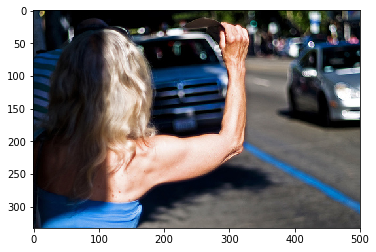

Greedy: a boy with his arms .
B=3: a young boy wearing a blue car .
B=5: a young boy in a blue car .
B=7: a teenage boy in a blue car .


In [92]:
pic = list(encoding_test.keys())[0]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

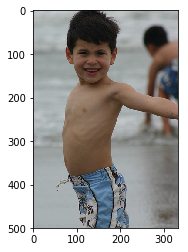

Greedy: a young boy in swim trunks is on the beach .
B=3: a young boy in swim trunks runs through the water .
B=5: a young boy in swim trunks holds a body of water .
B=7: a young boy runs through the water .


In [93]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

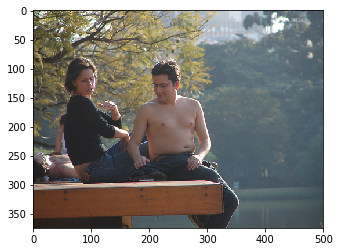

Greedy: a man in a green shirt and a park bench in front of a tree .
B=3: a man in a green shirt and looking at the park .
B=5: a man in a green shirt and looking at the park .
B=7: a man in a green shirt and looking at the park .


In [94]:
pic = list(encoding_test.keys())[2]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

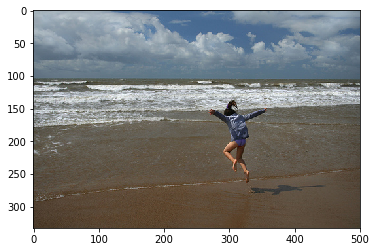

Greedy: a young girl in a bathing suit walks on the beach .
B=3: a little girl is on the beach at the beach .
B=5: a little girl is on the beach at the beach .
B=7: a child is on the beach at the beach .


In [95]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

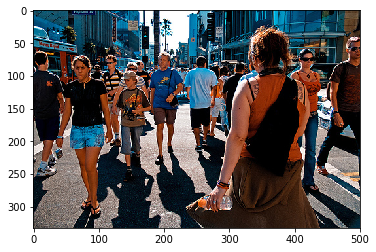

Greedy: a woman in a crowd in a city street .
B=3: a group of people on a city street .
B=5: a group of people on a city street .
B=7: a group of people on a city street .


In [96]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

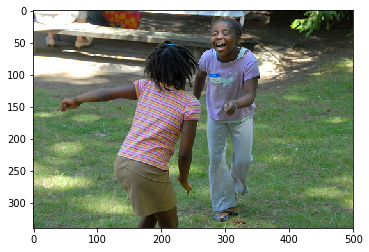

Greedy: a young girl in a striped shirt and shorts walks on a .
B=3: a young girl in a striped shirt and standing on a striped shirt .
B=5: a young girl in a striped shirt and pink skateboarding .
B=7: a young girl in a striped shirt and pink skateboarding .


In [97]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

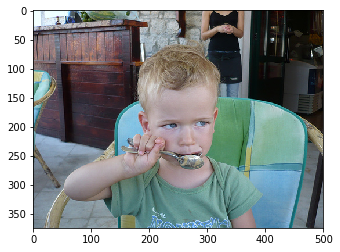

Greedy: a young girl in a blue shirt is blowing another boy with a .
B=3: a young girl in a blue shirt is blowing another boy with a red .
B=5: a young girl in a blue shirt plays with a .
B=7: a young girl in a blue shirt is playing with a .


In [98]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

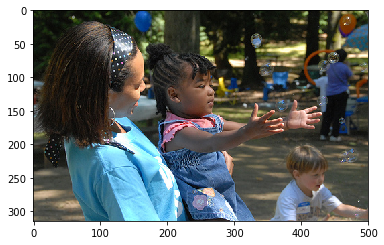

Greedy: a young girl in a blue shirt is standing in a crowd of people in the background .
B=3: a girl in a blue shirt is playing with a day .
B=5: a girl in a blue shirt is playing with a day .
B=7: a girl in a blue shirt is playing with a day .


In [99]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

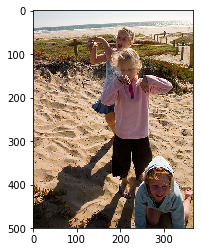

Greedy: a little girl in a white holding a long that is holding a large stick .
B=3: a little girl with a white bag at the edge of a in the water .
B=5: a little girl with a white holding a frisbee in the background .
B=7: a little girl with a white bag at the edge of a little girl in front of a .


In [100]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

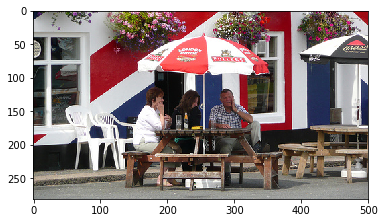

Greedy: a woman in a yellow jacket is riding a .
B=3: a woman in a yellow jacket is sitting on the street .
B=5: a woman in a at an amusement park ride .
B=7: a woman in a at an amusement park ride .


In [101]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

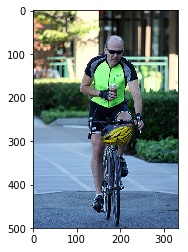

Greedy: a man in a yellow shirt riding a bike .
B=3: a man with a yellow bike in the background .
B=5: a man is riding a bike in front of a yellow and blue .
B=7: a man is riding a bike in front of a yellow and blue .


In [102]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

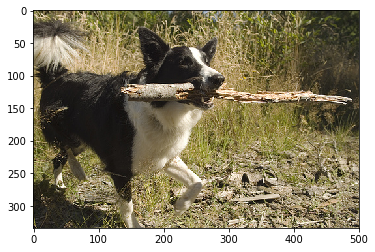

Greedy: a black and white dog is jumping in the air .
B=3: a black and white dog is jumping over a log in its mouth .
B=5: a black and white dog is jumping over a log in an obstacle course .
B=7: a black and white dog is running through the grass .


In [103]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

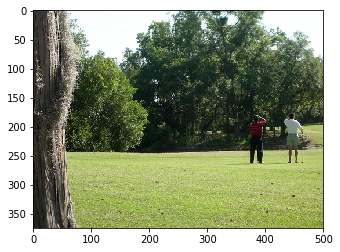

Greedy: two women in a field .
B=3: two women in red are standing in front of a field .
B=5: two women in red are standing in front of a grassy field .
B=7: there are two women in a field .


In [104]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

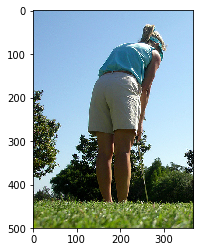

Greedy: a girl in a green shirt is on the ground .
B=3: a little girl in a field .
B=5: a little girl in the ground .
B=7: a little girl in a striped shirt hangs on the ground .


In [105]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

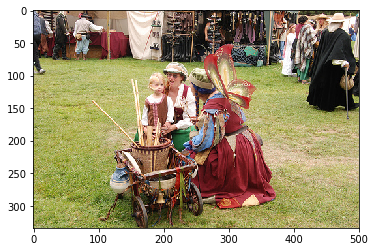

Greedy: a woman and a woman and a woman , and a woman , and a woman in a .
B=3: a woman , and a woman , and a woman , and a woman , and a cart , .
B=5: a woman and a man and a woman , and a woman , and a woman , and a .
B=7: a woman and a man and a woman , and a woman , and a woman , and a .


In [106]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

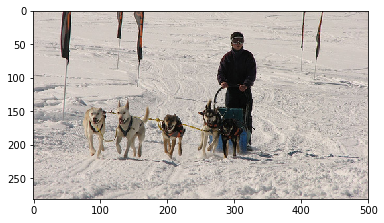

Greedy: a man and a sled pulled on a team in the snow .
B=3: four people are on a sled in the snow .
B=5: a group of people are on a sled dogs in the snow .
B=7: a group of people are on a sled pulled in the snow .


In [107]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

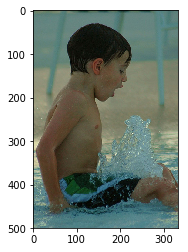

Greedy: a boy with a blue shorts is splashing in the water .
B=3: a young boy is splashing in the water .
B=5: a young boy plays in the water .
B=7: a young boy plays in the water .


In [108]:
i+=1
pic = list(encoding_test.keys())[i]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("B=3:", beamSearch(image, beam_width = 3))
print("B=5:", beamSearch(image, beam_width = 5))
print("B=7:", beamSearch(image, beam_width = 7))

* As observed this approch gives pretty good results but there are several images which are either slightly bad captioned or worse captioned.

* **Drawback** - On debugging this algorithm i found that the lstm is not doing any great work because all the work that lstm needs to be doing is done by us manually (pos,mask) ,so if we replace the lstm with just dense layer we can or are getting almost same results.

* There is another approch which genuinely using the power of lstm in captioning images (imgCaption3).